In [14]:
#Instalar las librerías necesarias si no las tienes instaladas
!pip install nltk
!pip install google-cloud-translate google-cloud-language
!pip install plotly

# Importar todas las librerías necesarias
import nltk
nltk.download('vader_lexicon')

# Librerías para análisis de sentimientos y autenticación en Google Cloud
from nltk.sentiment import SentimentIntensityAnalyzer
from google.colab import auth
from google.cloud import bigquery

# Librerías para manejo de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías adicionales para manejo de archivos
from google.colab import files

# Autenticación en Google Cloud
auth.authenticate_user()

# Configuración de BigQuery (puedes añadir tu project_id aquí)
project_id = 'datalab-433117'
client = bigquery.Client(project=project_id)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
from google.colab import auth
from google.cloud import bigquery

# Autenticación en Google Cloud
auth.authenticate_user()

# Configuración del proyecto de Google Cloud
project_id = 'datalab-433117'
client = bigquery.Client(project=project_id)

# Consulta en BigQuery para obtener los datos de la tabla 'new_amazon_review'
query = """
SELECT *
FROM `datalab-433117.dataset.new_amazon_reviews`
"""

# Ejecuta la consulta y convierte los resultados en un DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Muestra las primeras filas del DataFrame
df.head()

,user_id,user_name,review_id,review_title,review_content,img_link,product_link,product_id,rating,rating_count
0,AGE43ATINMGDC2ODRZNEM4Q2SEVQ,priyanshu jha,R1G8SZJG03IY67,Check the size !,"Value for money,Grt product,Please ensure the ...",https://m.media-amazon.com/images/I/51YPXDh78V...,https://www.amazon.in/Universal-Silicone-Keybo...,B00MFPCY5C,3.5,15233
1,AGIP2P2RM5LF2Z6NRCGYE6IZA27Q,Rajendra,RAYTSZHN0P9H5,Worth it product.......,"Typing is easy, comfortable and fast but keybo...",https://m.media-amazon.com/images/I/31BWFhkXiP...,https://www.amazon.in/HP-Multimedia-Wireless-K...,B07V82W5CN,4.0,7113
2,AGC6NVLEXXVXAOMXP46RL2622EBA,Lokesh K V,R3HWHOM95KCAZV,Good and average usage,"Battery life is low,Worth purchase,Good perfor...",https://m.media-amazon.com/images/I/41qqmdUWnh...,https://www.amazon.in/Noise-ColorFit-Display-M...,B09NVPSCQT,4.0,30254
3,AEDWWKMEJES5SUY5QRGMWWMM7CWA,Kavya Singh,R1LK91F22JFZ41,ठीक-ठाक hai ☺️,Camera and display is very poor quality and ba...,https://m.media-amazon.com/images/I/41WpD4fqT4...,https://www.amazon.in/Redmi-Charcoal-Storage-B...,B09XB8GFBQ,4.0,12796
4,AFNZPK76SJ4OIOZUZPZUKEDOMJQA,praneet arora,R22I6M8QU55OWI,Excellent sounding pair of earbuds with one fa...,The earphones have good clear sound quality. I...,https://m.media-amazon.com/images/I/31Sx7+mu+v...,https://www.amazon.in/Samsung-Galaxy-SM-R180NZ...,B08FN6WGDQ,4.0,4390


In [16]:
# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()

# Lista de palabras clave positivas y negativas
positive_keywords = ['good', 'great', 'excellent', 'amazing', 'fantastic']
negative_keywords = ['bad', 'poor', 'terrible', 'horrible', 'awful']

# Función para analizar el sentimiento con ajuste para palabras clave en review_title
def analyze_title_sentiment(text):
    sentiment = sia.polarity_scores(text)
    compound_score = sentiment['compound']

    # Ajuste basado en palabras clave
    text_lower = text.lower()
    if any(word in text_lower for word in positive_keywords):
        compound_score += 0.1  # Pequeño impulso positivo
    if any(word in text_lower for word in negative_keywords):
        compound_score -= 0.1  # Pequeño impulso negativo

    # Asignación de etiqueta basada en el puntaje ajustado
    if compound_score >= 0.3:
        sentiment_label = 'Positivo'
    elif compound_score <= -0.3:
        sentiment_label = 'Negativo'
    else:
        sentiment_label = 'Neutral'

    return compound_score, sentiment_label

# Aplicar el análisis de sentimientos solo a los títulos de las reseñas
df[['title_sentiment', 'title_sentiment_label']] = df['review_title'].apply(lambda x: pd.Series(analyze_title_sentiment(x)))

# Mostrar las primeras filas con el análisis de sentimientos del título
df[['review_title', 'title_sentiment', 'title_sentiment_label']].head()

,review_title,title_sentiment,title_sentiment_label
0,Check the size !,0.0000,Neutral
1,Worth it product.......,0.2263,Neutral
2,Good and average usage,0.5404,Positivo
3,ठीक-ठाक hai ☺️,0.0000,Neutral
4,Excellent sounding pair of earbuds with one fa...,0.1516,Neutral


In [17]:
# Función para analizar el sentimiento con ajuste para palabras clave en review_title
def analyze_title_sentiment(text):
    sentiment = sia.polarity_scores(text)
    compound_score = sentiment['compound']

    # Ajuste basado en palabras clave negativas
    text_lower = text.lower()
    if any(word in text_lower for word in ['good', 'great', 'excellent', 'amazing', 'fantastic']):
        compound_score += 0.2  # Incrementar impacto positivo
    if any(word in text_lower for word in ['bad', 'poor', 'terrible', 'horrible', 'awful', 'worst', 'disappointing', 'not good', 'not buy']):
        compound_score -= 0.4  # Incrementar impacto negativo

    # Asignación de etiqueta basada en el puntaje ajustado
    if compound_score >= 0.3:
        sentiment_label = 'Positivo'
    elif compound_score <= -0.3:
        sentiment_label = 'Negativo'
    else:
        sentiment_label = 'Neutral'

    return compound_score, sentiment_label

# Aplicar el análisis de sentimientos a los títulos de las reseñas
df[['title_sentiment', 'title_sentiment_label']] = df['review_title'].apply(lambda x: pd.Series(analyze_title_sentiment(x)))

# Agrupar la tabla por product_id
grouped_df = df.groupby('product_id').agg(
    review_content=('review_content', 'first'),  # Mantener review_content igual
    user_count=('user_name', 'count'),  # Conteo de usuarios
    user_names=('user_name', lambda x: ', '.join(x)),  # Agrupar user_name por product_id, separados por comas
    review_titles=('review_title', lambda x: ', '.join(x)),  # Agrupar review_title por product_id, separados por comas
    avg_sentiment=('title_sentiment', 'mean'),  # Promedio de los puntajes de sentimiento
).reset_index()

# Asignar una nueva etiqueta de sentimiento basada en el promedio
grouped_df['title_sentiment_label'] = grouped_df['avg_sentiment'].apply(lambda x: 'Positivo' if x >= 0.3 else 'Negativo' if x <= -0.3 else 'Neutral')

# Agregar las columnas que no se agruparon (mantenerlas igual que en el primer registro de cada grupo)
grouped_df = pd.merge(grouped_df, df[['product_id', 'img_link', 'product_link', 'rating', 'rating_count']].drop_duplicates(), on='product_id', how='left')

# Ordenar las columnas según lo especificado
final_df = grouped_df[['product_id', 'user_names', 'user_count', 'review_titles', 'review_content', 'img_link', 'product_link', 'rating', 'rating_count', 'avg_sentiment', 'title_sentiment_label']]

# Mostrar las primeras filas del DataFrame final para ver el resultado
final_df.head()
display(final_df)


,product_id,user_names,user_count,review_titles,review_content,img_link,product_link,rating,rating_count,avg_sentiment,title_sentiment_label
0,B002PD61Y4,"nilesh, arun, Ankur Awasthi, EAGLE, BALASUNDHA...",8,"good tool to use for, Good, Its not plug an pl...",good quality tool from d linkWiFi signal is go...,https://m.media-amazon.com/images/I/31+NwZ8gb1...,https://www.amazon.in/D-Link-DWA-131-Wireless-...,4.1,8131,0.463013,Positivo
1,B003B00484,"T N Sivaji, V, MOHAMMED, Akku, Tamil selvan, M...",8,"Works Good, Wow, A good product, Perfect repla...","Works good,Bought it to replace my Phillips QT...",https://m.media-amazon.com/images/I/418YrbHVLC...,https://www.amazon.in/Duracell-AAA-750mAh-Rech...,4.3,27201,0.538363,Positivo
2,B003L62T7W,"Hi, Dixit, Swarnavo Dutta, Simi Singh, chirag ...",8,"Good one., Quality + Less Price Makes it Best ...","Liked this Product,https://m.media-amazon.com/...",https://m.media-amazon.com/images/I/31iFF1Kbkp...,https://www.amazon.in/Logitech-B100-Optical-Mo...,4.3,31534,0.469350,Positivo
3,B004IO5BMQ,"wiki, Chandrashekar SK, dr.parimal ranajan de,...",8,"Its very small do take note of that, Good sil...",It's little small for big hands. But best avai...,https://m.media-amazon.com/images/I/31CtVvtFt+...,https://www.amazon.in/Logitech-M235-Wireless-M...,4.5,54405,0.292838,Neutral
4,B005FYNT3G,"Sujoy Paul, Sanjeet Tudu, Kartik Pandey, Anton...",8,"Good product 👍, Good product and value for mon...","Very chip very good,Really happy to buy this p...",https://m.media-amazon.com/images/I/310mw9KTJv...,https://www.amazon.in/SanDisk-Cruzer-Blade-Fla...,4.3,253105,0.512862,Positivo
...,...,...,...,...,...,...,...,...,...,...,...
1187,B0BPBXNQQT,"Eswar Babu, Rajiv Ranjan Singh, Vinay kumar, P...",8,"Better, Good for small rooms, Nice product, Go...",If u have to heat a small room you can definit...,None,None,4.3,70,0.482988,Positivo
1188,B0BPCJM7TB,"ramya, Ved, Priti Sharma, UMANG PATEL, Aman, S...",8,"Nice product I like this product, Good quality...",This is my first coffee frother and I just lov...,None,None,4.0,43,0.329238,Positivo
1189,B0BPJBTB3F,"Vidisha, Manidipa Sengupta",2,"Amazing product.., Bad quality",The heating capacity is zero .Moreover i have ...,None,None,2.0,2,-0.078200,Neutral
1190,B0BQ3K23Y1,"tharangini reddy, Neha Mehta, Ak, Nischal Agar...",8,"Good product, Great, Good product, My review a...","Overall, I love this Oratech Coffee frother an...",None,None,4.8,28,0.532537,Positivo


In [18]:
# Definir la paleta de colores de Amazon
amazon_colors = ['#000000', '#FF9900', '#146EB4', '#FFFFFF']

# Contar la cantidad de cada sentimiento
sentiment_counts = final_df['title_sentiment_label'].value_counts()

# Crear el gráfico circular
fig = px.pie(
    values=sentiment_counts.values,
    names=sentiment_counts.index,
    title='Distribución de Sentimientos',
    color_discrete_sequence=amazon_colors,  # Usar la paleta de colores de Amazon
    hole=0.4,  # Espacio en el centro del gráfico
)

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=700,  # Ajustar el ancho
    height=500,  # Ajustar la altura
    annotations=[dict(text='Sentimientos', x=0.5, y=0.5, font_size=18, showarrow=False)])


# Mostrar el gráfico
fig.show()


In [19]:
# Guardar la tabla agrupada y extendida en un nuevo archivo CSV
output_file_path = 'amazon_reviews_grouped_final_with_sentiment.csv'
final_df.to_csv(output_file_path, index=False)

# Descargar el archivo generado
from google.colab import files
files.download(output_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


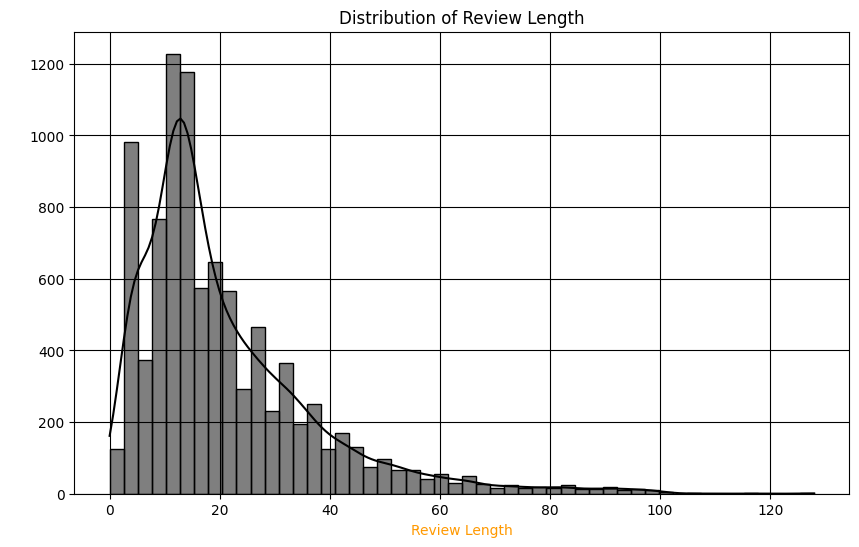

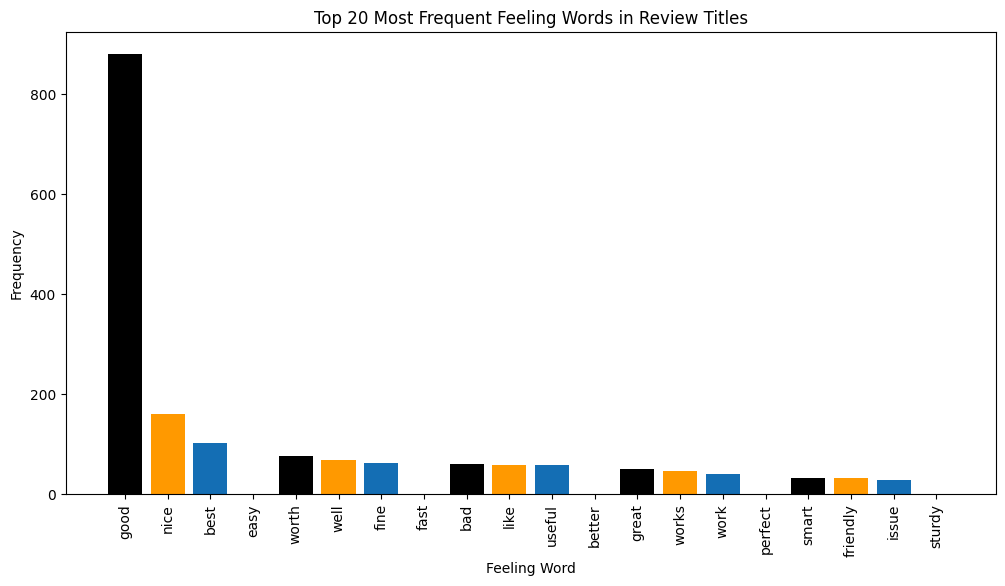

In [22]:
# Descargar opinion_lexicon (si no lo tienes)
!pip install nltk # install nltk if it's not already installed
import nltk # import the nltk library
nltk.download('opinion_lexicon')

# Lista de palabras positivas y negativas de la librería nltk
from nltk.corpus import opinion_lexicon # import the opinion_lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Análisis de la longitud de las reseñas
df['review_length'] = df['review_title'].apply(len)

# Visualización de la distribución de la longitud de las reseñas
import matplotlib.pyplot as plt # import matplotlib
import seaborn as sns # import seaborn

plt.figure(figsize=(10, 6))

# Histograma con la paleta de Amazon
sns.histplot(df['review_length'], bins=50, kde=True, color='#000000')  # Color principal

# Personalización del gráfico con los colores de la paleta de Amazon
plt.title('Distribution of Review Length', color='#000000')  # Título en color negro
plt.xlabel('Review Length', color='#FF9900')  # Etiqueta del eje x en color #FF9900
plt.ylabel('Frequency', color='#FFFFFF')  # Etiqueta del eje y en color blanco
plt.grid(True, color='#000000')  # Líneas de la cuadrícula en color negro

# Mostrar gráfico
plt.show()
print()

# Unir todos los títulos de reseñas procesados en un solo string
all_processed_titles = ' '.join(df['review_title'])

# Contar la frecuencia de cada palabra
from collections import Counter # import the Counter object from the collections module
word_counts = Counter(all_processed_titles.split())

# Filtrar solo las palabras que son referidas a sentimientos
feeling_words = {word: count for word, count in word_counts.items() if word in positive_words or word in negative_words}

# Obtener las 20 palabras más comunes referidas a sentimientos
top_20_feeling_words = Counter(feeling_words).most_common(20)

# Crear un gráfico de barras de las palabras más comunes relacionadas a sentimientos
plt.figure(figsize=(12, 6))

# Aplicar los colores de Amazon a las barras, alternando entre ellos
amazon_colors = ['#000000', '#FF9900', '#146EB4', '#FFFFFF']
colors = [amazon_colors[i % len(amazon_colors)] for i in range(len(top_20_feeling_words))]

plt.bar([word for word, count in top_20_feeling_words],
        [count for word, count in top_20_feeling_words],
        color=colors)  # Asignar colores de la paleta de Amazon

plt.xticks(rotation=90, color='#000000')  # Etiquetas de las palabras en negro
plt.title('Top 20 Most Frequent Feeling Words in Review Titles', color='#000000')  # Título en color negro
plt.xlabel('Feeling Word', color='#000000')  # Etiqueta en color negro
plt.ylabel('Frequency', color='#000000')  # Etiqueta en color negro
plt.show()

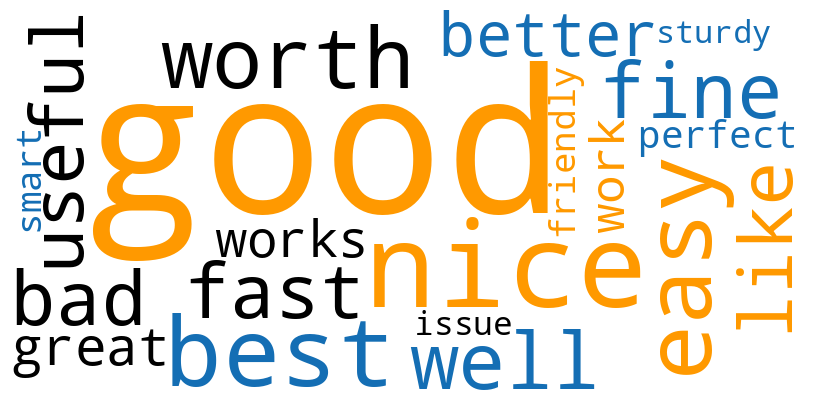

In [26]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import random

# Obtener las palabras y sus frecuencias del top 20
top_20_words = dict(top_20_feeling_words)

# Definir la paleta de colores de Amazon
amazon_colors = ['#000000', '#FF9900', '#146EB4']

# Función para generar colores aleatorios de la paleta de Amazon
def amazon_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(amazon_colors)

# Crear la nube de palabras
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    color_func=amazon_color_func,  # Usar la paleta de colores de Amazon
    stopwords=STOPWORDS,
    min_font_size=10
).generate_from_frequencies(top_20_words)

# Mostrar la nube de palabras
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()



In [27]:
# Crear un DataFrame con las palabras más comunes relacionadas a sentimientos
top_feeling_words_df = pd.DataFrame(top_20_feeling_words, columns=['Word', 'Frequency'])
display(top_feeling_words_df)

# Exportar el DataFrame a un archivo CSV
top_feeling_words_df.to_csv('top_feeling_words.csv', index=False)

# Descargar el archivo generado
files.download('top_feeling_words.csv')

,Word,Frequency
0,good,880
1,nice,159
2,best,101
3,easy,96
4,worth,76
5,well,67
6,fine,62
7,fast,60
8,bad,60
9,like,58


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>